# Explotation of multiomics data

The aim of this exercise is to visually divide samples by exposure by combining the proteomics- and transcriptomics data. Before being able to do this we need a way to translate sample names between the two analyses.

In [1]:
# First we load some libraries that we always need
# If you do not know what they are good for I suggest 
# three options:
# 1. Do not worry about this for now
# 2. Use google to find information
# 3. Ask somebody who might know
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(42)

First we read in the transcriptomics data by coping code from the transcriptomics notebook.

In [2]:
# Import tool used to walk throug the files
from os import walk
# In order to make the code cleaner it is often usefull
# to specify values in variables. Here we specify the file
# path, that is, the folder to fetch files from
path = '../rawdata/In vivo II transcriptomics/'
# Now we walk through all filenames in the specified folder
(_, _, filenames) = next(walk(path))
# We only keep the file ending with xlsx, that is, the excel files
transcriptomics_filenames = [path + name for name in filenames if name.endswith('.csv')]

In [3]:
# Helper method for reading in multiple csv files and 
# formatting them for use in the analysis
from itertools import chain
def read_csv_files(filepaths, max_null_columns=None):
    '''
    Read in excel files. 
    '''
    # Force the filepaths to consist of a list of filepaths also
    # when a single filename is given as input
    if type(filepaths) == str:
        filepaths = [filepaths]
    # Read in the content of all csv files
    datas = [pd.read_csv(filepath, index_col=0) for filepath
        in filepaths]
    doses = [[filepath.split()[-1].split('/')[-1][:4]] * df.shape[1]
             for filepath, df in zip(filepaths, datas)]
    # Format the individual spreadsheets
    '''
    for idx, df in enumerate(datas):
        # Discard empty columns
        df = df.dropna(how='all', axis=1)
        # Discard columns with no name
        df = df[df.index.notnull()]
        # Discard duplicate columns keeping biggest values.
        df_dup = df.loc[df.index.duplicated(keep=False)]
        df = df.loc[~df.index.duplicated(keep=False)]
        for name in np.unique(df_dup.index):
            df.loc[name] = df_dup.loc[name].max(axis=0).values
        datas[idx] = df
    '''
    # Merge all spreadsheets into one spreadsheet
    df = pd.concat(datas, axis=1, sort=False)
    # Discard duplicate columns
    # df = df.loc[:,~df.columns.duplicated()]
    # Discard all rows with more than `max_null_columns` empty entries
    df = df.replace(0, pd.np.nan)
    if max_null_columns is None:
        max_null_columns = df.shape[1]
    df = df.loc[df.isnull().sum(axis=1) <= max_null_columns]
    # Fill in empty entries with columnwise minima
    mins = df.min()
    df = df.fillna(value=mins)
    # Return then resulting spreadsheet. We will call it a DataFrame from now on.
    return df, np.array(list(chain.from_iterable(doses)))

Now we read in the csv files.

In [4]:
df_transcriptimics, doses_transcriptomics = read_csv_files(
    transcriptomics_filenames, max_null_columns=0)

In [5]:
df_transcriptimics.columns = [int(name.split('_')[1]) for name in df_transcriptimics.columns]

In [6]:
df_transcriptimics.head()

532        533        536        538        540  \
ENSGMOG00000000001   5.895429   7.580259   5.988031   3.197445   3.664780   
ENSGMOG00000000002   5.243531   3.838597   5.961058   2.671838   4.716152   
ENSGMOG00000000004  10.912212  17.855290  14.916132  18.089656  10.543753   
ENSGMOG00000000006  13.491463  11.903527  14.700347  12.088971  12.766653   
ENSGMOG00000000007   1.558887   3.198830   1.105898   2.321433   1.531998   

                          545        546        547        411        412  \
ENSGMOG00000000001   6.194208   5.696718   5.078485   6.392699   6.851931   
ENSGMOG00000000002   4.942187   4.970291   3.742042   3.800384   4.656805   
ENSGMOG00000000004  13.673385  17.166620  12.128225  18.372719  15.632438   
ENSGMOG00000000006  15.024250  13.725649   9.822860  10.495101  12.982607   
ENSGMOG00000000007   1.910979   1.146990   2.639476   1.988281   2.132409   

                    ...        458        459        460        461  \
ENSGMOG00000000001  ...   3.357936   3.691421   5.426208   3.403650   
ENSGMOG00000000002  ...   3.503934   6.174342   4.584433   3.721324   
ENSGMOG00000000004  ...   7.591856  13.579157  11.448133  10.755533   
ENSGMOG00000000006  ...  11.784062  18.193434  11.344530  15.354242   
ENSGMOG00000000007  ...   3.378793   2.482920   2.227465   2.284227   

                          462        463        464        465        467  \
ENSGMOG00000000001   3.860613   4.484287   3.776216   4.658480   5.061770   
ENSGMOG00000000002   4.440820   3.709515   4.283469   3.493860   3.404114   
ENSGMOG00000000004   7.966698   7.066861   6.199758   9.102424   9.857131   
ENSGMOG00000000006  10.912368  13.452861  13.554925  11.646199  10.330747   
ENSGMOG00000000007   1.629045   1.244331   0.873602   1.777578   1.894464   

                          468  
ENSGMOG00000000001   4.334030  
ENSGMOG00000000002   4.267353  
ENSGMOG00000000004  11.801897  
ENSGMOG00000000006  12.735380  
ENSGMOG00000000007   1.500241  

[5 rows x 81 columns]

Next we read in the proteomics data.

In [7]:
# Import tool used to walk throug the files
from os import walk
# In order to make the code cleaner it is often usefull
# to specify values in variables. Here we specify the file
# path, that is, the folder to fetch files from
path = '../rawdata/In vivo II proteomics/'
# Now we walk through all filenames in the specified folder
(_, _, filenames) = next(walk(path))
# We only keep the file ending with xlsx, that is, the excel files
filenames = [path + name for name in filenames if name.endswith('.xlsx')]

In [8]:
# Helper method for reading in multiple excel files and 
# formatting them for use in the analysis
def read_excel_files(filepaths, max_null_columns=None):
    '''
    Read in excel files. 
    '''
    # Force the filepaths to consist of a list of filepaths also
    # when a single filename is given as input
    if type(filepaths) == str:
        filepaths = [filepaths]
    # Read in the content of all spreadsheets
    datas = [pd.read_excel(io=filepath, index_col=0) for filepath
        in filepaths]
    # Format the individual spreadsheets
    for idx, df in enumerate(datas):
        # Discard empty columns
        df = df.dropna(how='all', axis=1)
        # Discard columns with no name
        df = df[df.index.notnull()]
        # Discard duplicate columns keeping biggest values.
        df_dup = df.loc[df.index.duplicated(keep=False)]
        df = df.loc[~df.index.duplicated(keep=False)]
        for name in np.unique(df_dup.index):
            df.loc[name] = df_dup.loc[name].max(axis=0).values
        datas[idx] = df
    # Merge all spreadsheets into one spreadsheet
    df = pd.concat(datas, axis=1, sort=False)
    # Discard duplicate columns
    df = df.loc[:,~df.columns.duplicated()]
    # Discard all rows with more than `max_null_columns` empty entries
    if max_null_columns is not None:
        df = df.loc[df.isnull().sum(axis=1) <= max_null_columns]
    # Fill in empty entries with columnwise minima
    mins = df.min()
    df = df.fillna(value=mins)
    # Return then resulting spreadsheet. We will call it a DataFrame from now on.
    return df

In [9]:
df_proteomics = read_excel_files(filenames, max_null_columns=0)

In [10]:
def short_dose_name(dose):
    words = dose.split()
    if words[-1][-1] in {'1', '2'}:
        return words[0][0] + words[-1][-1]
    else:
        return ''.join([word[0] for word in dose.split()])

In [11]:
doses_proteomics = np.array([short_dose_name(name.split(',')[-1]) for name in df_proteomics.columns])

Unfortunately quite some work needs to be done in order to have the same sample names in both the proteomics and the transcriptomics data set.

In [12]:
name_table_path = '../rawdata/In_vivo_II_sample_names/TMT-experiment.xlsx'

In [13]:
df_names = pd.read_excel(name_table_path)

In [14]:
reporter_names = df_names['Sample number_reporter_experiment'].values
sample_names = df_names['Sample Name'].values
reporter_names = [name.split('_')[1] for name in reporter_names[:-2]]

In [15]:
sample_names = [name[-3:] if isinstance(name, str) else name for name in sample_names]

In [16]:
name_dict = dict(zip(reporter_names, sample_names))

In [17]:
import re

In [18]:
df_proteomics.columns = [
    int(name_dict[name.split()[3][:-1] + '-' + re.findall(r'\d+', name.split()[2])[0]])
    for name in df_proteomics.columns]

Finally we are ready to combine the proteomics and the transscriptomics data sets into one table

In [19]:
df = pd.concat([df_proteomics, df_transcriptimics], axis=0, join='inner')

Now we need to organize the exposure doses with regard to the combined samples.

In [20]:
dose_dict = dict(zip(df_proteomics.columns, doses_proteomics))

In [21]:
doses = np.array([dose_dict[sample] for sample in df.columns])

### Magic data manipulation. 

Next we do some preprocessing with arc sine hyperbolic and both normalization and scaling. (Check these modules on the documentation of sklearn. Google is your friend here.)

In [22]:
df[df.columns] = np.arcsinh(df[df.columns].astype(float) / 5)

In [23]:
from sklearn.preprocessing import Normalizer

In [24]:
normalizer = Normalizer()
df[df.columns] = normalizer.fit_transform(df.values)

In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
scaler = StandardScaler()
scaler.fit(df.values)
df[df.columns] = scaler.transform(df.values)

We take average of gene expressions for each exposure group.

In [27]:
# Construct auxillary dataframes holding the flipped and averaged expressions
df2 = df.transpose()
df2['doses'] = doses
df2groups = df2.groupby('doses')
# Extract the averaged expressions in a numpy array
fit_values = df2groups.mean().values
# Clean up by deleting the auxillary dataframes
del df2
del df2groups

Finally we reduce dimensionality by principal components. We use as many principal components as the data supports. There is a trick here. The mean values over exposures are used to find principal components but the individual samples are transformed by these principal components. This way we have learned something about the effect of the different exposures.

In [28]:
# Import PCA module
from sklearn.decomposition import PCA
# Fit and transform PCA
pca = PCA(n_components=5).fit(fit_values)
print('explained_variance_ratio', np.cumsum(pca.explained_variance_ratio_))
X = pca.transform(df.values.transpose())

explained_variance_ratio [0.35746306 0.53928366 0.69296633 0.79385419 0.87556864]


### Visualization


We define a helper function for plotting. It takes several inputs.
* X is two-dimensional data that will be plotted by placing abbreviated dose names in the appropritat position on the plane
* y_text holds the dose abbreviations
* y_color specifies the colors. To begin with we want text and color to correspond.

In [29]:
from itertools import cycle, islice
def plot_embedding(X, y_text, y_color=None, title=None, colors=None, outliers=False):
    if y_color is None:
        y_color = y_text
    if colors is None:
        palette = np.vstack((plt.cm.tab10(np.arange(10)), plt.cm.Set3(np.arange(12))))
        palette = np.array(list(islice(cycle(palette), len(np.unique(y_color)))))
        if outliers:
            palette = np.vstack(([0,0,0,1], palette))
        colors = {}
        for idx, value in enumerate(np.unique(y_color)):
            colors[value] = palette[idx]
    x_min, x_max = np.min(X, axis=0), np.max(X, axis=0)
    dimensions = x_max - x_min
    x_max = x_max + 0.1*dimensions
    x_min = x_min - 0.05*dimensions

    #plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y_text[i]),
                 color=colors[y_color[i]],
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xlim([x_min[0], x_max[0]])
    plt.ylim([x_min[1], x_max[1]])
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

We make a list of dosage abbreviations

In [30]:
y_dose = np.empty(len(doses), dtype=int)
for idx, dose in enumerate(np.unique(doses)):
    y_dose[np.array(doses) == dose] = idx

Compute UMAP embedding intended to visualize the data

### Plot the data

First we plot the first two principal components

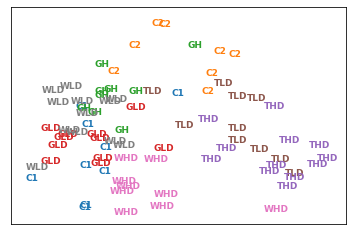

In [31]:
plot_embedding(X[:, [0, 1]], 
               doses, 
               y_color=y_dose, colors=None)

Next we compute a fancy embedding of the all principal components.

In [32]:
# Import UMAP module
from umap import UMAP
# Suppress annoying warnings
import warnings
warnings.filterwarnings('ignore')
Y = UMAP(n_components=2).fit_transform(X)

And plot it

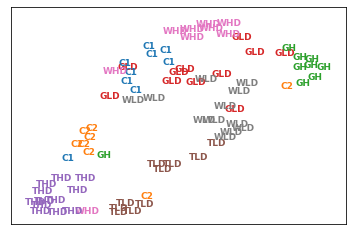

In [33]:
plot_embedding(Y, 
               doses, 
               y_color=y_dose, colors=None)

In [34]:
Y.shape

(80, 2)

### Clustering

Now that we know that the data reflects the exposures we might appempt to automatically sort the data into exposure gorups. This is what clustering algorithms do for us. We use one of the more recent algorithms called hdbscan.

In [35]:
import hdbscan

Instead of using the two-dimensional imbedding `Y` to form clusters we produce a new embedding `Z` of dimension as high as the data allows.

In [36]:
Z = UMAP(n_components=min(X.shape)).fit_transform(X)

Here some trail and error has been invested to find suitable parameters. 

In [37]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1)

In [38]:
cluster_labels = clusterer.fit_predict(Z)

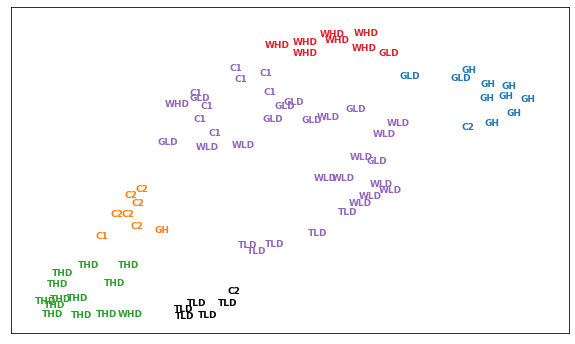

In [39]:
plt.figure(figsize=(10,6))
plot_embedding(Y, 
               doses, 
               y_color=cluster_labels,
               outliers=True,
               colors=None)